In [1]:
import pandas as pd
data_dir = "../data/"
price = pd.read_csv(data_dir + "processed/item_price_lag_filled.csv")
print(price.head())
trend = pd.read_csv(data_dir + "raw/nst_광어_trend_2025-01-17.csv")
print(trend.head())

trend['age'].unique()

    priceDate item market  minPrice  avgPrice  maxPrice  avgPrice_lag_1  \
0  2015-02-25   광어   가락시장   25000.0   25000.0   25000.0             NaN   
1  2015-02-26   광어   가락시장   25000.0   25000.0   25000.0         25000.0   
2  2015-02-27   광어   가락시장   25000.0   25000.0   25000.0         25000.0   
3  2015-02-28   광어   가락시장   25000.0   25000.0   25000.0         25000.0   
4  2015-03-01   광어   가락시장   25000.0   25000.0   25000.0         25000.0   

   avgPrice_lag_2  avgPrice_lag_3  avgPrice_lag_7  
0             NaN             NaN             NaN  
1             NaN             NaN             NaN  
2         25000.0             NaN             NaN  
3         25000.0         25000.0             NaN  
4         25000.0         25000.0             NaN  
   idx    age name     score        date
0    0  06_12   광어  1.398471  2016-01-01
1    1  06_12   광어  2.725172  2016-01-02
2    2  06_12   광어  1.090436  2016-01-03
3    3  06_12   광어  1.110405  2016-01-04
4    4  06_12   광어  1.492906  20

array(['06_12', '13_18', '19_24', '25_29', '30_34', '35_39', '40_44',
       '45_49', '50_54', '55_59', '60_80'], dtype=object)

In [8]:
def gen_merge_dataset(
    fill, 
    item, 
    drop_cols=[], 
    age=['06_12', '13_18', '19_24', '25_29', '30_34', '35_39', '40_44', '45_49', '50_54', '55_59', '60_80']
):
    price_file = "item_price_lag_filled.csv" if fill == True else "item_price_lag.csv"
    price = pd.read_csv(data_dir + "processed/" + price_file)
    trend = pd.read_csv(data_dir + f"raw/nst_{item}_trend_2025-01-17.csv")
    
    trend = trend[trend["age"].isin(age)]
    
    # 날짜 컬럼 변환
    price["priceDate"] = pd.to_datetime(price["priceDate"])
    trend["date"] = pd.to_datetime(trend["date"])

    # 월 정보 추가
    price["month"] = price["priceDate"].dt.month.astype("category")

    # 요일 정보 추가 (0: 월요일, 6: 일요일)
    price["day_of_week"] = price["priceDate"].dt.dayofweek.astype("category")

    # 하루 전 날짜 계산
    price["merge_date"] = price["priceDate"] - pd.Timedelta(days=1)
    
    # trend 데이터에서 age와 name별로 score 값을 새로운 컬럼으로 변환
    trend_pivot = trend.pivot_table(
        # index="date", columns=["age", "name"], values="score"
        index="date", columns="age", values="score"
    )

    # 멀티 인덱스를 플랫하게 변환
    # trend_pivot.columns = [f"{col[0]}_{col[1]}" for col in trend_pivot.columns]
    trend_pivot.columns = [f"age_{col}" for col in trend_pivot.columns]
    
    # 병합
    ignored_cols = ["minPrice", "maxPrice"] + drop_cols  # 분석에 포함하지 않을 컬럼
    price = price.drop(columns=ignored_cols)
    
    merged_data = pd.merge(price, trend_pivot, left_on="merge_date", right_on="date", how="left")

    # 필요 없는 컬럼 제거
    merged_data.drop(columns=["merge_date", "priceDate"], inplace=True)

    # 결측값 제거
    merged_data = merged_data.dropna()
    
    # 레코드 제거
    merged_data = merged_data[merged_data["item"] == item]

    return merged_data

In [13]:
df_merged = gen_merge_dataset(fill=False, item="광어", drop_cols=[
    "avgPrice_lag_1", "avgPrice_lag_2", "avgPrice_lag_3", "avgPrice_lag_7"
])
df_merged.info()
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
Index: 26526 entries, 136 to 27157
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   avgPrice     26526 non-null  int64   
 1   item         26526 non-null  object  
 2   market       26526 non-null  object  
 3   month        26526 non-null  category
 4   day_of_week  26526 non-null  category
 5   age_06_12    26526 non-null  float64 
 6   age_13_18    26526 non-null  float64 
 7   age_19_24    26526 non-null  float64 
 8   age_25_29    26526 non-null  float64 
 9   age_30_34    26526 non-null  float64 
 10  age_35_39    26526 non-null  float64 
 11  age_40_44    26526 non-null  float64 
 12  age_45_49    26526 non-null  float64 
 13  age_50_54    26526 non-null  float64 
 14  age_55_59    26526 non-null  float64 
 15  age_60_80    26526 non-null  float64 
dtypes: category(2), float64(11), int64(1), object(2)
memory usage: 3.1+ MB


,avgPrice,item,market,month,day_of_week,age_06_12,age_13_18,age_19_24,age_25_29,age_30_34,age_35_39,age_40_44,age_45_49,age_50_54,age_55_59,age_60_80
136,31250,광어,가락시장,1,5,1.398471,1.522796,1.813454,1.902568,1.791911,1.762563,1.681463,1.644956,1.653369,2.156606,1.532954
137,31670,광어,가락시장,1,0,1.090436,1.434030,1.915274,1.766822,1.888905,1.812398,1.670650,1.818188,1.505182,1.774184,1.677356
138,32500,광어,가락시장,1,1,1.110405,1.423285,1.589437,1.859699,1.728730,1.498392,1.349096,1.462454,1.844893,1.827577,1.940197
139,31250,광어,가락시장,1,2,1.492906,1.423285,1.626851,1.774267,1.734848,1.587863,1.412948,1.755730,1.134811,1.349090,1.000000
140,31670,광어,가락시장,1,3,1.331215,1.511904,1.858294,1.590691,1.519752,1.492377,1.479155,1.774597,1.467025,2.162987,1.313399


In [10]:
import pandas as pd
from pycaret.regression import setup, compare_models, get_config, pull
import matplotlib.pyplot as plt
import koreanize_matplotlib

def run_automl_feature_importance(data):
    # PyCaret 설정
    setup(
        data=data,
        target="avgPrice",
        session_id=1030,  # 재현성을 위한 난수 시드
        normalize=True,  # 데이터 스케일링
        verbose=False
    )

    # 여러 모델 비교 및 최적 모델 선정
    best_model = compare_models(
        include=["rf", "lightgbm", "xgboost", "catboost"],
        verbose=False)
    
    # 최적 모델 이름과 평가지표 출력
    print("Best Model:", type(best_model).__name__)
    print("Model Performance Metrics:")
    metrics = pull()  # PyCaret에서 비교된 모델들의 평가지표를 가져옴
    print(metrics.loc[metrics.index[0]])  # 최적 모델의 성능만 출력
    
    importances = best_model.feature_importances_
    processed_features = get_config("X_train_transformed").columns
    feature_importance_df = pd.DataFrame({
        "Feature": processed_features,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    
    plt.figure(figsize=(10, 6))
    feature_importance_df.plot(kind="bar", x="Feature", y="Importance", legend=False, color="skyblue")
    plt.title("Feature Importance")
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    return best_model




Best Model: XGBRegressor
Model Performance Metrics:
Model       Extreme Gradient Boosting
MAE                         1409.1062
MSE                      3863700.7605
RMSE                        1965.0338
R2                             0.8365
RMSLE                          0.0553
MAPE                           0.0401
TT (Sec)                        0.205
Name: xgboost, dtype: object


<Figure size 1000x600 with 0 Axes>

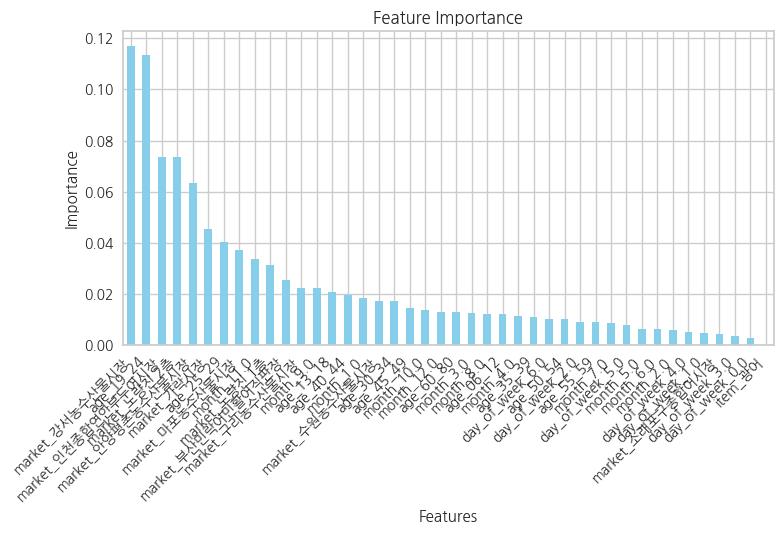

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=1030, ...)

In [11]:
run_automl_feature_importance(df_merged)

농어 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               3418.9672
MSE                           17429572.7548
RMSE                              4174.5096
R2                                   0.3599
RMSLE                                0.1192
MAPE                                 0.0987
TT (Sec)                              0.196
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

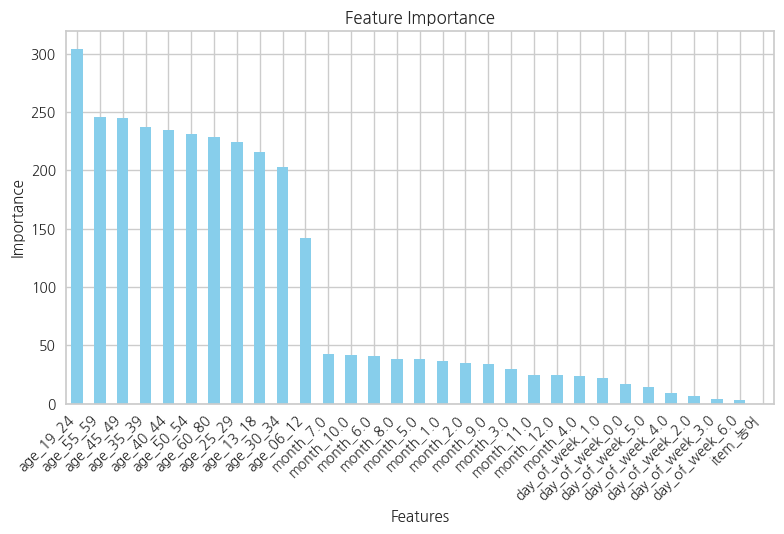

농어 filled False
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               3475.8498
MSE                           17893482.8751
RMSE                                4229.73
R2                                   0.3448
RMSLE                                0.1204
MAPE                                 0.0999
TT (Sec)                              0.237
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

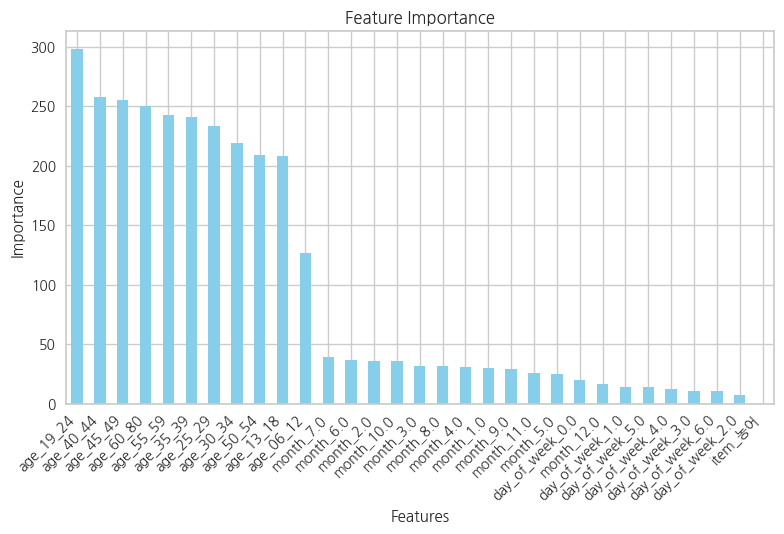

광어 filled True
Best Model: CatBoostRegressor
Model Performance Metrics:
Model       CatBoost Regressor
MAE                  2744.0349
MSE              12058343.1262
RMSE                 3472.1449
R2                      0.4874
RMSLE                   0.0945
MAPE                    0.0765
TT (Sec)                 1.092
Name: catboost, dtype: object


<Figure size 1000x600 with 0 Axes>

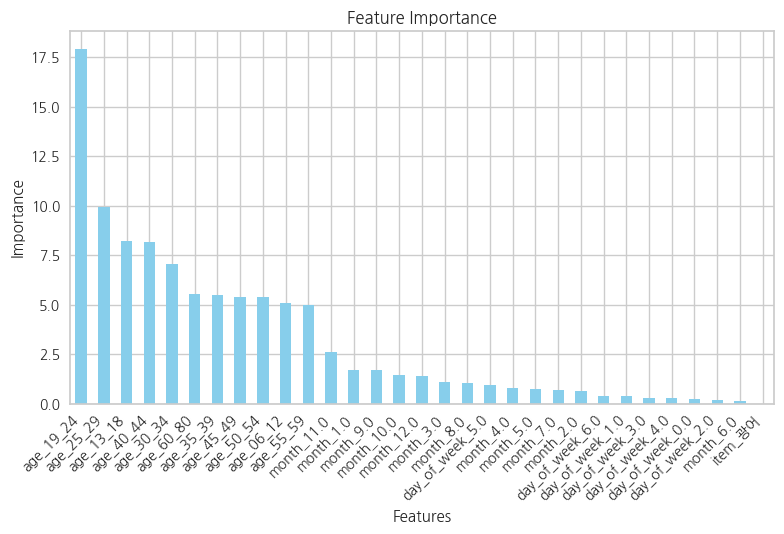

광어 filled False
Best Model: CatBoostRegressor
Model Performance Metrics:
Model       CatBoost Regressor
MAE                     2742.3
MSE              12201905.9884
RMSE                 3492.4164
R2                      0.4842
RMSLE                   0.0941
MAPE                    0.0757
TT (Sec)                 1.086
Name: catboost, dtype: object


<Figure size 1000x600 with 0 Axes>

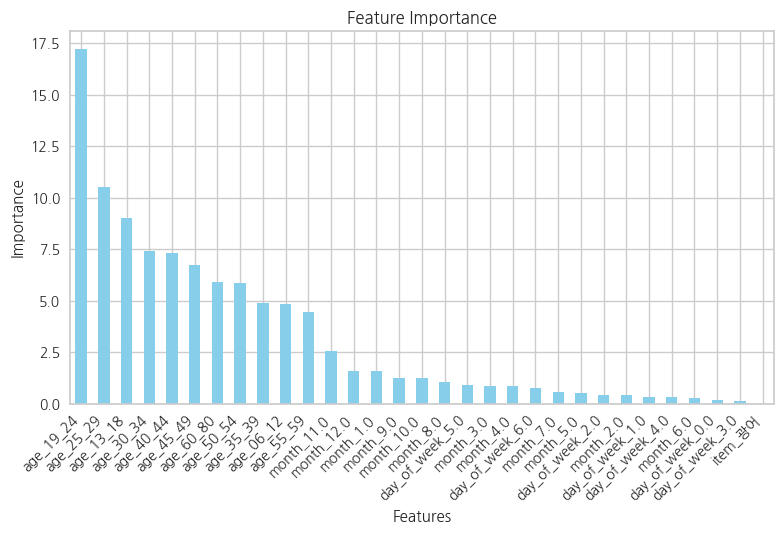

대게 filled True
Best Model: CatBoostRegressor
Model Performance Metrics:
Model       CatBoost Regressor
MAE                  6099.6508
MSE              60047186.7986
RMSE                 7747.9778
R2                      0.6571
RMSLE                   0.1448
MAPE                    0.1163
TT (Sec)                 1.108
Name: catboost, dtype: object


<Figure size 1000x600 with 0 Axes>

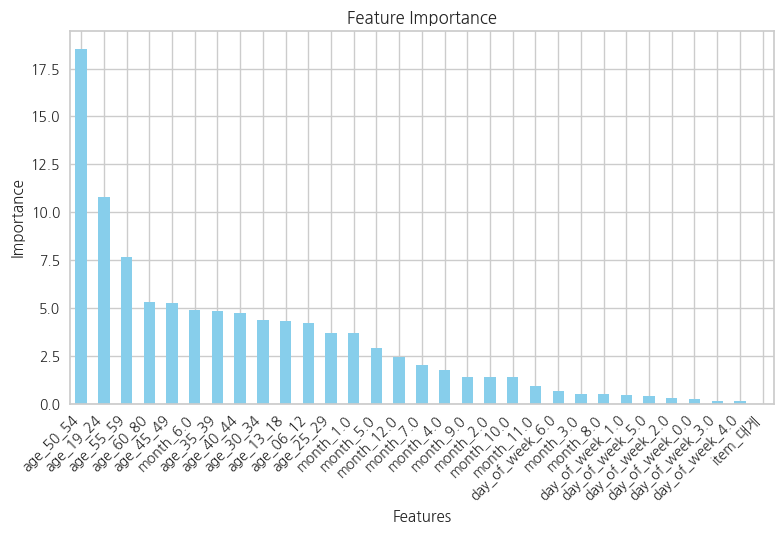

대게 filled False
Best Model: CatBoostRegressor
Model Performance Metrics:
Model       CatBoost Regressor
MAE                  6000.1875
MSE              58712636.5155
RMSE                 7661.9746
R2                      0.6646
RMSLE                   0.1408
MAPE                    0.1124
TT (Sec)                 0.955
Name: catboost, dtype: object


<Figure size 1000x600 with 0 Axes>

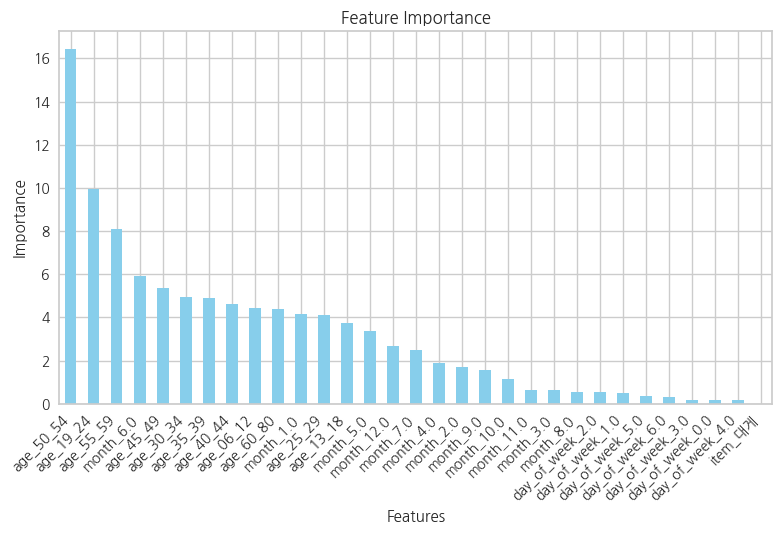

연어 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                                 545.171
MSE                             475144.0055
RMSE                               689.0238
R2                                   0.7119
RMSLE                                0.1369
MAPE                                 0.1161
TT (Sec)                              0.266
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

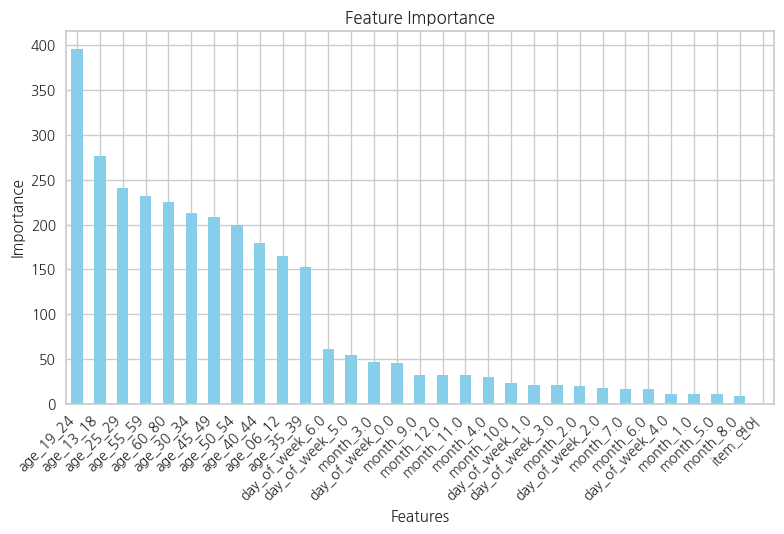

연어 filled False
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                                540.5898
MSE                             469204.4975
RMSE                               684.7127
R2                                   0.7236
RMSLE                                0.1345
MAPE                                 0.1138
TT (Sec)                              0.271
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

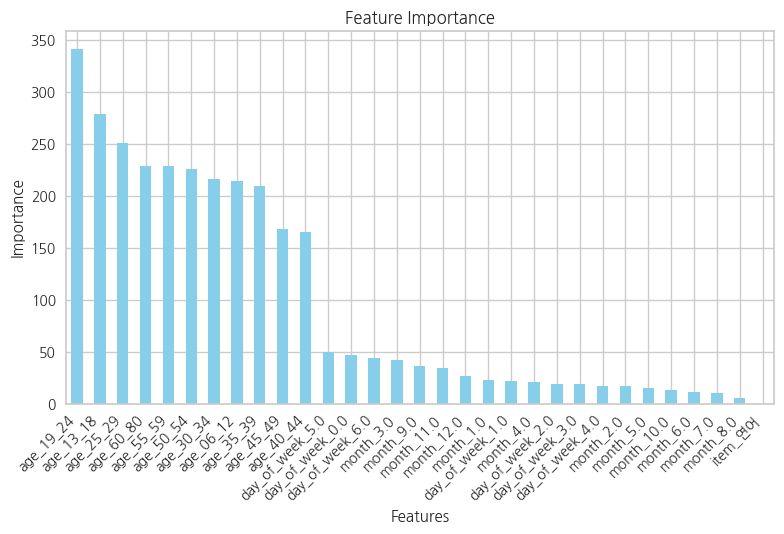

우럭 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               3487.9214
MSE                           18549248.4422
RMSE                              4306.0599
R2                                  -0.2268
RMSLE                                0.1286
MAPE                                 0.1057
TT (Sec)                              0.259
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

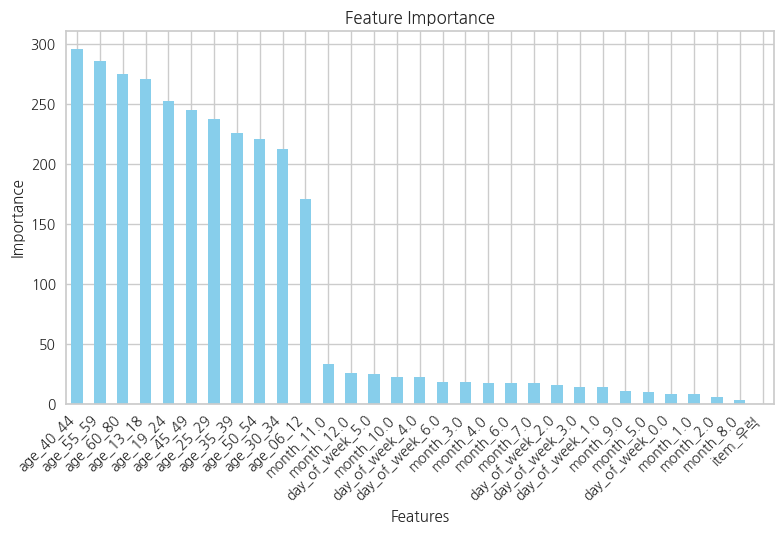

우럭 filled False
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               3560.2668
MSE                           19265612.8487
RMSE                              4386.5825
R2                                  -0.2371
RMSLE                                0.1312
MAPE                                  0.108
TT (Sec)                              0.245
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

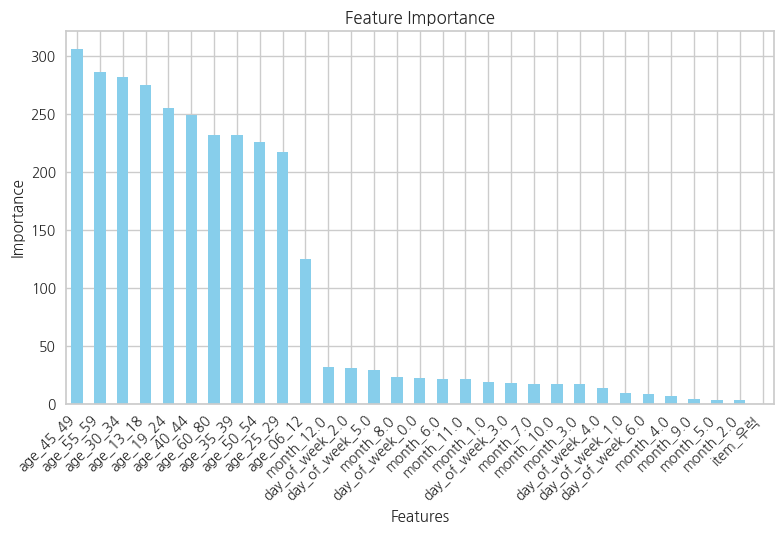

참돔 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               2752.8759
MSE                           11948330.0759
RMSE                              3456.4142
R2                                   0.1228
RMSLE                                0.0938
MAPE                                 0.0756
TT (Sec)                              0.252
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

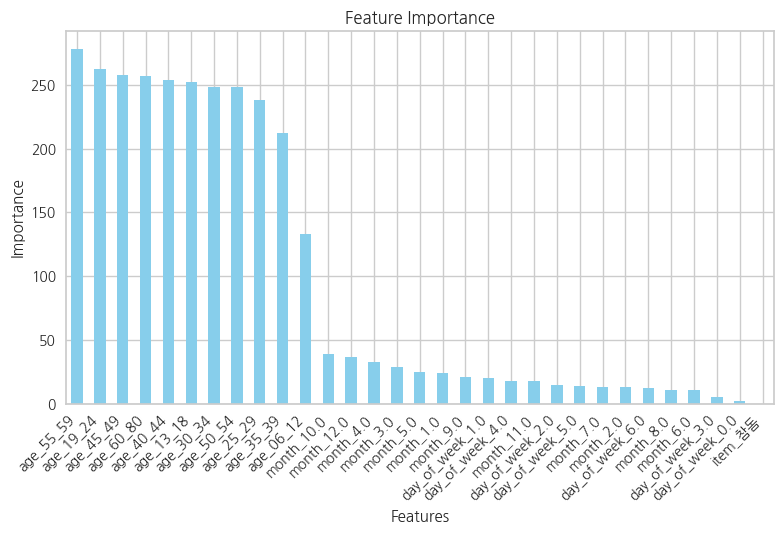

참돔 filled False
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               2863.6688
MSE                           12502097.7535
RMSE                               3535.252
R2                                   0.1599
RMSLE                                0.0956
MAPE                                 0.0785
TT (Sec)                              0.248
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

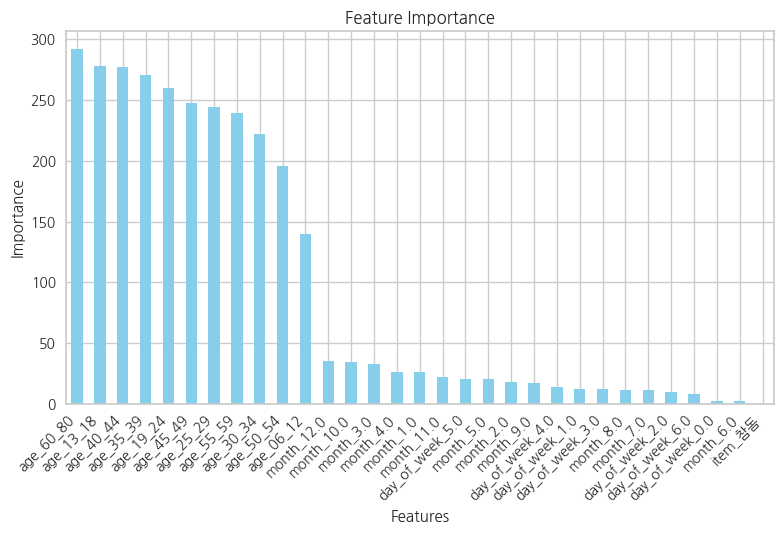

방어 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               5892.8326
MSE                           49115188.4516
RMSE                               7007.686
R2                                   0.1106
RMSLE                                0.2058
MAPE                                 0.1781
TT (Sec)                              0.244
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

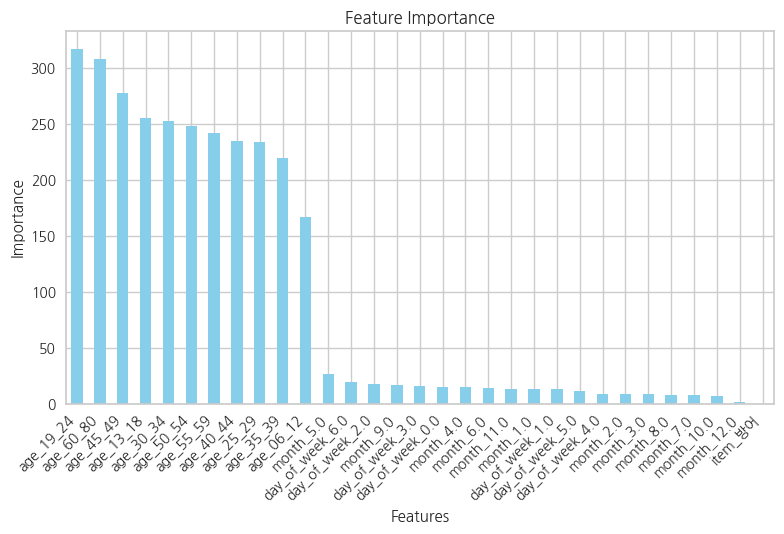

방어 filled False
Best Model: RandomForestRegressor
Model Performance Metrics:
Model       Random Forest Regressor
MAE                       4978.5608
MSE                   39657863.5613
RMSE                      6274.7483
R2                           0.2325
RMSLE                        0.1709
MAPE                         0.1357
TT (Sec)                      0.087
Name: rf, dtype: object


<Figure size 1000x600 with 0 Axes>

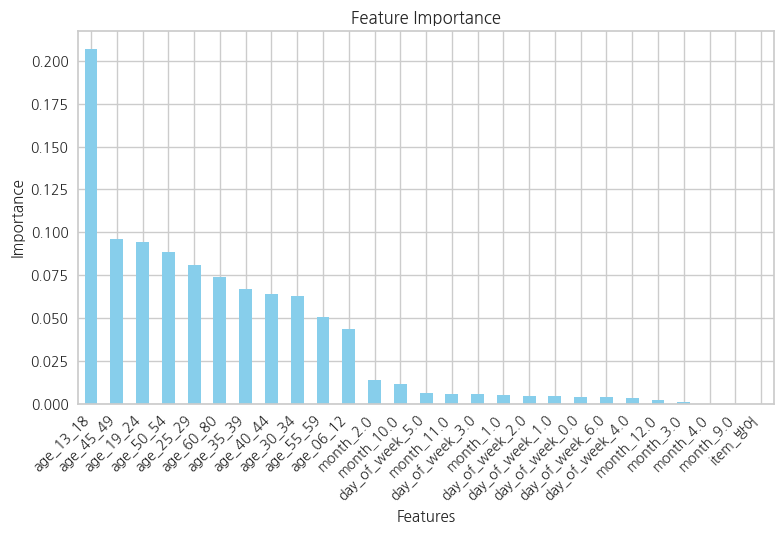

In [12]:
item_list = ['농어', '광어', '대게', '연어', '우럭', '참돔', '방어']
for item in item_list:
    for fill in [True, False]:
        print(item, 'filled', fill)
        df_merged = gen_merge_dataset(fill=fill, item=item, drop_cols=[
            "avgPrice_lag_1", "avgPrice_lag_2", "avgPrice_lag_3", "avgPrice_lag_7", "market"
        ])
        run_automl_feature_importance(df_merged)